In [1]:
# Imports
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import date
import sklearn
pd.set_option("display.max_columns", None, "display.max_rows", None)
import missingno as msno


In [2]:
internet_logs = pd.read_csv("https://raw.githubusercontent.com/JosephLazarus/QTW/main/Case%20Study%205/Data/log2.csv")

internet_logs.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


In [3]:
internet_logs.shape

(65532, 12)

In [4]:
internet_logs.columns

Index(['Source Port', 'Destination Port', 'NAT Source Port',
       'NAT Destination Port', 'Action', 'Bytes', 'Bytes Sent',
       'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent',
       'pkts_received'],
      dtype='object')

In [5]:
internet_logs.Action.groupby(internet_logs.Action).count()

Action
allow         37640
deny          14987
drop          12851
reset-both       54
Name: Action, dtype: int64

#### Reset both 

Represents less than .001% of data. Making decesion to remove. 

In [6]:
internet_logs = internet_logs[internet_logs.Action != "reset-both"]
internet_logs.shape

(65478, 12)

In [7]:
# Check for duplicate rows
print('Duplicate rows: ',internet_logs.duplicated(keep='first').sum())

Duplicate rows:  8362


## Duplicates

Need more information on these duplicates. Are they repeated values or independent observations. 
for now will remove

In [8]:
logs_no_duplicates = internet_logs.drop_duplicates(keep='first')

In [9]:
logs_no_duplicates.shape

(57116, 12)

In [10]:
logs_no_duplicates.isna().sum()

Source Port             0
Destination Port        0
NAT Source Port         0
NAT Destination Port    0
Action                  0
Bytes                   0
Bytes Sent              0
Bytes Received          0
Packets                 0
Elapsed Time (sec)      0
pkts_sent               0
pkts_received           0
dtype: int64

In [11]:
logs_no_duplicates.columns = logs_no_duplicates.columns.str.replace(r" ", "_")

In [12]:
logs_no_duplicates.columns

Index(['Source_Port', 'Destination_Port', 'NAT_Source_Port',
       'NAT_Destination_Port', 'Action', 'Bytes', 'Bytes_Sent',
       'Bytes_Received', 'Packets', 'Elapsed_Time_(sec)', 'pkts_sent',
       'pkts_received'],
      dtype='object')

In [13]:
logs_no_duplicates.dtypes

Source_Port              int64
Destination_Port         int64
NAT_Source_Port          int64
NAT_Destination_Port     int64
Action                  object
Bytes                    int64
Bytes_Sent               int64
Bytes_Received           int64
Packets                  int64
Elapsed_Time_(sec)       int64
pkts_sent                int64
pkts_received            int64
dtype: object

In [14]:
logs_no_duplicates["Action"].value_counts()

allow    37439
drop     11635
deny      8042
Name: Action, dtype: int64

In [15]:
logs_no_duplicates['Action'] = logs_no_duplicates['Action'].replace(['drop'],'deny')

C:\Users\Joey\AppData\Local\Temp\ipykernel_25004\3601792291.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  logs_no_duplicates['Action'] = logs_no_duplicates['Action'].replace(['drop'],'deny')


In [16]:
drop_cols = [
'Source_Port',
'Destination_Port',
'NAT_Source_Port',
'NAT_Destination_Port'
]
logs_no_duplicates = logs_no_duplicates.drop(drop_cols, axis=1)

## Split data into training = 70% , validation = 20%, test = 10%

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
for train_index, holdback_index in split.split(logs_no_duplicates, logs_no_duplicates.Action):
    training_df = logs_no_duplicates.iloc[train_index]
    holdback_df = logs_no_duplicates.iloc[holdback_index]

In [18]:
print(training_df.shape)
print(holdback_df.shape)

(34269, 8)
(22847, 8)


In [19]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for validation_index, test_index in split.split(holdback_df, holdback_df.Action):
    validation_df = holdback_df.iloc[validation_index]
    test_df = holdback_df.iloc[test_index]

In [20]:
print(training_df.shape)
print(validation_df.shape)
print(test_df.shape)

(34269, 8)
(20562, 8)
(2285, 8)


In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder


Numericals_to_scale = ['Bytes', 'Bytes_Sent','Bytes_Received', 'Packets', 'Elapsed_Time_(sec)', 'pkts_sent','pkts_received']

scl_obj = StandardScaler()
scl_obj.fit(training_df[Numericals_to_scale])
training_df[Numericals_to_scale] = scl_obj.transform(training_df[Numericals_to_scale])
validation_df[Numericals_to_scale] = scl_obj.transform(validation_df[Numericals_to_scale])
test_df[Numericals_to_scale] = scl_obj.transform(test_df[Numericals_to_scale])

training_df.Action = LabelEncoder().fit_transform(training_df.Action)
validation_df.Action = LabelEncoder().fit_transform(validation_df.Action)
test_df.Action = LabelEncoder().fit_transform(test_df.Action)


training_df.head()


C:\Users\Joey\AppData\Local\Temp\ipykernel_25004\796339914.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_df[Numericals_to_scale] = scl_obj.transform(training_df[Numericals_to_scale])
C:\Users\Joey\AppData\Local\Temp\ipykernel_25004\796339914.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_df[Numericals_to_scale] = scl_obj.transform(validation_df[Numericals_to_scale])
C:\Users\Joey\AppData\Local\Temp\ipykernel_25004\796339914.py:11: SettingWithCopyWarning: 
A value is trying to

,Action,Bytes,Bytes_Sent,Bytes_Received,Packets,Elapsed_Time_(sec),pkts_sent,pkts_received
13617,1,-0.034423,-0.010145,-0.033539,-0.039585,-0.237601,-0.039582,-0.036425
50338,0,-0.034369,-0.010139,-0.033484,-0.038728,-0.202884,-0.039582,-0.035262
1859,1,-0.034425,-0.010154,-0.033539,-0.039585,-0.237601,-0.039582,-0.036425
33154,0,-0.034376,-0.010103,-0.033501,-0.039156,-0.142918,-0.039582,-0.035844
2078,0,-0.034370,-0.010090,-0.033498,-0.039156,-0.133449,-0.039582,-0.035844


In [22]:
validation_df.head()

,Action,Bytes,Bytes_Sent,Bytes_Received,Packets,Elapsed_Time_(sec),pkts_sent,pkts_received
63761,0,-0.033901,-0.009793,-0.033087,-0.037442,3.549735,-0.036919,-0.034681
39918,1,-0.034423,-0.010145,-0.033539,-0.039585,-0.237601,-0.039582,-0.036425
16142,1,-0.034421,-0.010139,-0.033539,-0.039585,-0.237601,-0.039582,-0.036425
49278,0,-0.027072,-0.003621,-0.027594,-0.026728,0.365217,-0.022273,-0.026539
37659,0,-0.034394,-0.010127,-0.033514,-0.039156,-0.221820,-0.039582,-0.035844


## Random Forest to compare to SVM SGD models

In [23]:
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score


scorer = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score)
}

In [24]:
#Create new X predictor matrix for training
X_train = training_df.drop(['Action'],axis=1).values #droping target
y_train = training_df['Action'].values

#Create new X predictor matrix for validation
X_validation = validation_df.drop(['Action'],axis=1).values #droping target
y_validation = validation_df['Action'].values

#Create new X predictor matrix for test
X_test = test_df.drop(['Action'],axis=1).values #droping target
y_test = test_df['Action'].values


In [25]:
print(y_train.shape)
print(y_validation.shape)
print(y_test.shape)

(34269,)
(20562,)
(2285,)


In [26]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

training_model = rf.fit(X_train,y_train)
rf_validation_predictions = training_model.predict(X_validation)

print(rf_validation_predictions)

from sklearn.metrics import classification_report
print(classification_report(y_validation,rf_validation_predictions, 
                            target_names=['allow','deny']))

[0 1 1 ... 1 0 1]
              precision    recall  f1-score   support

       allow       1.00      1.00      1.00     13478
        deny       1.00      1.00      1.00      7084

    accuracy                           1.00     20562
   macro avg       1.00      1.00      1.00     20562
weighted avg       1.00      1.00      1.00     20562



In [27]:
print("Validation Set Accuracy: ", precision_score(y_validation, rf_validation_predictions))


Validation Set Accuracy:  0.999717633771001


In [28]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
for train_index, holdback_index in split.split(logs_no_duplicates, 
                                               logs_no_duplicates.Action):
    training_df_encoded = logs_no_duplicates.iloc[train_index]
    holdback_df_encoded = logs_no_duplicates.iloc[holdback_index]

print("Size of training set: ",training_df_encoded.shape)
print("Size of hold back set to be split into validation/test: ",holdback_df_encoded.shape)


Size of training set:  (34269, 8)
Size of hold back set to be split into validation/test:  (22847, 8)


In [29]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for validation_index, test_index in split.split(holdback_df_encoded, holdback_df_encoded.Action):
    validation_df_encoded = holdback_df_encoded.iloc[validation_index]
    test_df_encoded = holdback_df_encoded.iloc[test_index]

print("Size of training set: ",training_df_encoded.shape)
print("Size of validation set: ",validation_df_encoded.shape)
print("Size of test set: ",test_df_encoded.shape)


Size of training set:  (34269, 8)
Size of validation set:  (20562, 8)
Size of test set:  (2285, 8)


In [30]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

training_df_encoded.Action = LabelEncoder().fit_transform(training_df_encoded.Action)
validation_df_encoded.Action = LabelEncoder().fit_transform(validation_df_encoded.Action)
test_df_encoded.Action = LabelEncoder().fit_transform(test_df_encoded.Action)

training_df_encoded.head()

C:\Users\Joey\AppData\Local\Temp\ipykernel_25004\1031785471.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_df_encoded.Action = LabelEncoder().fit_transform(training_df_encoded.Action)
C:\Users\Joey\AppData\Local\Temp\ipykernel_25004\1031785471.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_df_encoded.Action = LabelEncoder().fit_transform(validation_df_encoded.Action)
C:\Users\Joey\AppData\Local\Temp\ipykernel_25004\1031785471.py:5: SettingWithCopyWarning: 
A value is trying to 

,Action,Bytes,Bytes_Sent,Bytes_Received,Packets,Elapsed_Time_(sec),pkts_sent,pkts_received
13617,1,66,66,0,1,0,1,0
50338,0,202,70,132,3,11,1,2
1859,1,60,60,0,1,0,1,0
33154,0,184,94,90,2,30,1,1
2078,0,200,102,98,2,33,1,1


In [31]:
#Create new X predictor matrix for training
X_train_encoded = training_df_encoded.drop(['Action'],axis=1).values #droping target

#Create new X predictor matrix for validation
X_validation_encoded = validation_df_encoded.drop(['Action'],axis=1).values #droping target

#Create new X predictor matrix for validation
X_test_encoded = test_df_encoded.drop(['Action'],axis=1).values #droping target


In [32]:
print(X_train_encoded.shape)
print(X_validation_encoded.shape)
print(X_test_encoded.shape)

(34269, 7)
(20562, 7)
(2285, 7)


# Linear Support Vector

In [33]:
from sklearn.svm import LinearSVC

SVC_linear_base = LinearSVC()

training_model = SVC_linear_base.fit(X_train_encoded,y_train)
SVC_linear_base_validation_predictions = training_model.predict(X_validation_encoded)

print(SVC_linear_base_validation_predictions)

from sklearn.metrics import classification_report
print(classification_report(y_validation,SVC_linear_base_validation_predictions, 
                            target_names=['allow','deny']))

[0 1 1 ... 1 0 1]
              precision    recall  f1-score   support

       allow       1.00      1.00      1.00     13478
        deny       1.00      1.00      1.00      7084

    accuracy                           1.00     20562
   macro avg       1.00      1.00      1.00     20562
weighted avg       1.00      1.00      1.00     20562



C:\Users\Joey\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [34]:
print("Validation Set Accuracy: ", accuracy_score(y_validation, SVC_linear_base_validation_predictions))


Validation Set Accuracy:  0.9997568329928995


In [35]:
print(SVC_linear_base.get_params())

{'C': 1.0, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}


# Grid search for optimal parameters

In [36]:
from sklearn.model_selection import GridSearchCV

parameters = {'C':[1,10,100,1000], 'loss':['hinge', 'squared_hinge']}

clf = LinearSVC()

import warnings

with warnings.catch_warnings():
   warnings.simplefilter('ignore')
   grid_obj = GridSearchCV(clf, parameters, cv = 2, verbose=1, n_jobs = 6, scoring='accuracy')
   grid_obj = grid_obj.fit(X_train_encoded, y_train)

print("Best Accuracy: ",grid_obj.best_score_)
print("Best Parameters: ",grid_obj.best_params_)


Fitting 2 folds for each of 8 candidates, totalling 16 fits
Best Accuracy:  0.9995039256811233
Best Parameters:  {'C': 100, 'loss': 'hinge'}


In [37]:
from sklearn.model_selection import GridSearchCV

parameters = {'C':[1], 'loss':['hinge'], 'tol':[1e-6, 1e-4, 1e-2], 'max_iter':[1000, 2000, 5000]}

clf = LinearSVC()

import warnings

with warnings.catch_warnings():
   warnings.simplefilter('ignore')
   grid_obj = GridSearchCV(clf, parameters, cv = 2, verbose=1, n_jobs = 6, scoring='accuracy')
   grid_obj = grid_obj.fit(X_train_encoded, y_train)

print("Best Accuracy: ",grid_obj.best_score_)
print("Best Parameters: ",grid_obj.best_params_)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
Best Accuracy:  0.9997665528609877
Best Parameters:  {'C': 1, 'loss': 'hinge', 'max_iter': 5000, 'tol': 0.0001}


In [38]:
SVC_linear_tuned = LinearSVC(C=1, loss='hinge', max_iter=1000, tol=1e-6)

training_model = SVC_linear_tuned.fit(X_train_encoded,y_train)
SVC_linear_tuned_validation_predictions = training_model.predict(X_validation_encoded)

print("Validation Set Accuracy: ", accuracy_score(y_validation, SVC_linear_tuned_validation_predictions))


from sklearn.metrics import classification_report
print(classification_report(y_validation,SVC_linear_tuned_validation_predictions, 
                            target_names=['allow','deny']))

Validation Set Accuracy:  0.9948448594494699
              precision    recall  f1-score   support

       allow       1.00      0.99      1.00     13478
        deny       0.99      1.00      0.99      7084

    accuracy                           0.99     20562
   macro avg       0.99      1.00      0.99     20562
weighted avg       0.99      0.99      0.99     20562



C:\Users\Joey\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [39]:
SVC_linear_tuned_test_predictions = training_model.predict(X_test_encoded)
print("Test Set Accuracy: ", accuracy_score(y_test, SVC_linear_tuned_test_predictions))



Test Set Accuracy:  0.9938730853391685


## SVC modeling with different kernels

In [40]:
training_samples=5000
X_train_encoded_reduced = X_train_encoded[1:training_samples+1,]
y_train_reduced = y_train[1:training_samples+1,]

from sklearn.svm import SVC

parameters = {'C': [0.1,1, 10],'kernel': ['rbf', 'poly', 'sigmoid']}

clf = SVC()

import warnings

with warnings.catch_warnings():
   warnings.simplefilter('ignore')
   grid_obj = GridSearchCV(clf, parameters, cv = 2, verbose=1, n_jobs = 6, scoring='accuracy')
   grid_obj = grid_obj.fit(X_train_encoded_reduced, y_train_reduced)

print("Best Accuracy: ",grid_obj.best_score_)
print("Best Parameters: ",grid_obj.best_params_)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
Best Accuracy:  0.6574
Best Parameters:  {'C': 0.1, 'kernel': 'rbf'}


In [41]:
#Use best params to get a check on validation accuracy

training_samples=5000
X_train_encoded_reduced = X_train_encoded[1:training_samples+1,]
y_train_reduced = y_train[1:training_samples+1,]


SVC_base = SVC(C=.10,kernel='rbf')

training_model = SVC_base.fit(X_train_encoded_reduced,y_train_reduced)
SVC_base_validation_predictions = training_model.predict(X_validation_encoded)

print("Validation Set Accuracy: ", accuracy_score(y_validation, SVC_base_validation_predictions))

from sklearn.metrics import classification_report
print(classification_report(y_validation,SVC_base_validation_predictions, 
                            target_names=['allow','deny']))


Validation Set Accuracy:  0.6554809843400448
              precision    recall  f1-score   support

       allow       0.66      1.00      0.79     13478
        deny       0.00      0.00      0.00      7084

    accuracy                           0.66     20562
   macro avg       0.33      0.50      0.40     20562
weighted avg       0.43      0.66      0.52     20562



C:\Users\Joey\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Joey\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Joey\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
training_samples=5000
X_train_encoded_reduced = X_train_encoded[1:training_samples+1,]
y_train_reduced = y_train[1:training_samples+1,]

from sklearn.svm import SVC

parameters = {'C': [1, 10],'kernel': ['rbf'],'gamma':['scale', 'auto'],'tol':[1e-6, 1e-3], 'max_iter':[-1],'decision_function_shape':['ovo', 'ovr']}

clf = SVC()

import warnings

with warnings.catch_warnings():
   warnings.simplefilter('ignore')
   grid_obj = GridSearchCV(clf, parameters, cv = 2, verbose=1, n_jobs = 6, scoring='accuracy')
   grid_obj = grid_obj.fit(X_train_encoded_reduced, y_train_reduced)

print("Best Accuracy: ",grid_obj.best_score_)
print("Best Parameters: ",grid_obj.best_params_)

Fitting 2 folds for each of 16 candidates, totalling 32 fits
Best Accuracy:  0.9958
Best Parameters:  {'C': 10, 'decision_function_shape': 'ovo', 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': -1, 'tol': 1e-06}


In [43]:
#Use best params to get a check on validation accuracy

from sklearn.svm import SVC

training_samples=5000
X_train_encoded_reduced = X_train_encoded[1:training_samples+1,]
y_train_reduced = y_train[1:training_samples+1,]

SVC_base = SVC(C=10, decision_function_shape='ovo', gamma='auto', kernel='rbf', tol= 1e-06)

training_model = SVC_base.fit(X_train_encoded_reduced,y_train_reduced)
SVC_base_validation_predictions = training_model.predict(X_validation_encoded)

print("Validation Set Accuracy: ", accuracy_score(y_validation, SVC_base_validation_predictions))

from sklearn.metrics import classification_report
print(classification_report(y_validation,SVC_base_validation_predictions, 
                            target_names=['allow','deny']))

Validation Set Accuracy:  0.996449761696333
              precision    recall  f1-score   support

       allow       0.99      1.00      1.00     13478
        deny       1.00      0.99      0.99      7084

    accuracy                           1.00     20562
   macro avg       1.00      0.99      1.00     20562
weighted avg       1.00      1.00      1.00     20562



In [44]:
SVC_base_test_predictions = training_model.predict(X_test_encoded)
print("Test Set Accuracy: ", accuracy_score(y_test, SVC_base_test_predictions))



Test Set Accuracy:  0.9973741794310722


In [45]:
#Use best params to get a check on validation accuracy

from sklearn.svm import SVC

training_samples=10000
X_train_encoded_reduced = X_train_encoded[1:training_samples+1,]
y_train_reduced = y_train[1:training_samples+1,]

SVC_base = SVC(C=10, decision_function_shape='ovo', gamma='auto', kernel='rbf', tol= 1e-06)

training_model = SVC_base.fit(X_train_encoded_reduced,y_train_reduced)
SVC_base_validation_predictions = training_model.predict(X_validation_encoded)

print("Validation Set Accuracy: ", accuracy_score(y_validation, SVC_base_validation_predictions))

from sklearn.metrics import classification_report
print(classification_report(y_validation,SVC_base_validation_predictions, 
                            target_names=['allow','deny']))

Validation Set Accuracy:  0.9970333625133742
              precision    recall  f1-score   support

       allow       1.00      1.00      1.00     13478
        deny       1.00      0.99      1.00      7084

    accuracy                           1.00     20562
   macro avg       1.00      1.00      1.00     20562
weighted avg       1.00      1.00      1.00     20562



In [46]:
SVC_base_test_predictions = training_model.predict(X_test_encoded)
print("Test Set Accuracy: ", accuracy_score(y_test, SVC_base_test_predictions))

Test Set Accuracy:  0.9973741794310722


# SKLEARN SGD

In [47]:
from sklearn.linear_model import SGDClassifier

training_samples=5000
X_train_encoded_reduced = X_train_encoded[1:training_samples+1,]
y_train_reduced = y_train[1:training_samples+1,]

SGD_base = SGDClassifier()

training_model = SGD_base.fit(X_train_encoded_reduced,y_train_reduced)
SGD_base_validation_predictions = training_model.predict(X_validation_encoded)

print("Validation Set Accuracy: ", accuracy_score(y_validation, SGD_base_validation_predictions))

from sklearn.metrics import classification_report
print(classification_report(y_validation,SGD_base_validation_predictions, 
                            target_names=['allow','deny']))

Validation Set Accuracy:  0.6554809843400448
              precision    recall  f1-score   support

       allow       0.66      1.00      0.79     13478
        deny       0.00      0.00      0.00      7084

    accuracy                           0.66     20562
   macro avg       0.33      0.50      0.40     20562
weighted avg       0.43      0.66      0.52     20562



C:\Users\Joey\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Joey\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Joey\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
SGD_base_test_predictions = training_model.predict(X_test_encoded)
print("Test Set Accuracy: ", accuracy_score(y_test, SGD_base_test_predictions))


Test Set Accuracy:  0.6555798687089716


In [49]:
from sklearn.linear_model import SGDClassifier

training_samples=10000
X_train_encoded_reduced = X_train_encoded[1:training_samples+1,]
y_train_reduced = y_train[1:training_samples+1,]

SGD_base = SGDClassifier()

training_model = SGD_base.fit(X_train_encoded_reduced,y_train_reduced)
SGD_base_validation_predictions = training_model.predict(X_validation_encoded)

print("Validation Set Accuracy: ", accuracy_score(y_validation, SGD_base_validation_predictions))

from sklearn.metrics import classification_report
print(classification_report(y_validation,SGD_base_validation_predictions, 
                            target_names=['allow','deny']))

Validation Set Accuracy:  0.9754401322828519
              precision    recall  f1-score   support

       allow       1.00      0.97      0.98     13478
        deny       0.94      0.99      0.97      7084

    accuracy                           0.98     20562
   macro avg       0.97      0.98      0.97     20562
weighted avg       0.98      0.98      0.98     20562



In [50]:
SGD_base_test_predictions = training_model.predict(X_test_encoded)
print("Test Set Accuracy: ", accuracy_score(y_test, SGD_base_test_predictions))

Test Set Accuracy:  0.9698030634573304


In [51]:
from sklearn.linear_model import SGDClassifier

training_samples=15000
X_train_encoded_reduced = X_train_encoded[1:training_samples+1,]
y_train_reduced = y_train[1:training_samples+1,]

SGD_base = SGDClassifier()

training_model = SGD_base.fit(X_train_encoded_reduced,y_train_reduced)
SGD_base_validation_predictions = training_model.predict(X_validation_encoded)

print("Validation Set Accuracy: ", accuracy_score(y_validation, SGD_base_validation_predictions))

from sklearn.metrics import classification_report
print(classification_report(y_validation,SGD_base_validation_predictions, 
                            target_names=['allow','deny']))

Validation Set Accuracy:  0.6554809843400448
              precision    recall  f1-score   support

       allow       0.66      1.00      0.79     13478
        deny       0.00      0.00      0.00      7084

    accuracy                           0.66     20562
   macro avg       0.33      0.50      0.40     20562
weighted avg       0.43      0.66      0.52     20562



C:\Users\Joey\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Joey\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Joey\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
SGD_base_test_predictions = training_model.predict(X_test_encoded)
print("Test Set Accuracy: ", accuracy_score(y_test, SGD_base_test_predictions))

Test Set Accuracy:  0.6555798687089716


In [53]:
from sklearn.linear_model import SGDClassifier

#Full training set

SGD_base = SGDClassifier()

training_model = SGD_base.fit(X_train_encoded,y_train)
SGD_base_validation_predictions = training_model.predict(X_validation_encoded)

print("Validation Set Accuracy: ", accuracy_score(y_validation, SGD_base_validation_predictions))

from sklearn.metrics import classification_report
print(classification_report(y_validation,SGD_base_validation_predictions, 
                            target_names=['allow','deny']))

Validation Set Accuracy:  0.975488765684272
              precision    recall  f1-score   support

       allow       1.00      0.97      0.98     13478
        deny       0.94      0.99      0.97      7084

    accuracy                           0.98     20562
   macro avg       0.97      0.98      0.97     20562
weighted avg       0.98      0.98      0.98     20562



In [54]:
SGD_base_test_predictions = training_model.predict(X_test_encoded)
print("Test Set Accuracy: ", accuracy_score(y_test, SGD_base_test_predictions))

Test Set Accuracy:  0.9680525164113786


In [55]:
from sklearn.model_selection import GridSearchCV

training_samples=5000
X_train_encoded_reduced = X_train_encoded[1:training_samples+1,]
y_train_reduced = y_train[1:training_samples+1,]

from sklearn.svm import SVC

parameters = {
    'loss':['hinge'],
    'penalty':['l2'],
    'alpha':[0.00001, 0.0001, 0.001, 0.01],
}

clf = SGDClassifier()

import warnings

with warnings.catch_warnings():
   warnings.simplefilter('ignore')
   grid_obj = GridSearchCV(clf, parameters, cv = 2, verbose=1, n_jobs = 6, scoring='accuracy')
   grid_obj = grid_obj.fit(X_train_encoded_reduced, y_train_reduced)

print("Best Accuracy: ",grid_obj.best_score_)
print("Best Parameters: ",grid_obj.best_params_)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
Best Accuracy:  0.9743999999999999
Best Parameters:  {'alpha': 0.0001, 'loss': 'hinge', 'penalty': 'l2'}


In [56]:
print("Best Accuracy: ",grid_obj.best_score_)
print("Best Parameters: ",grid_obj.best_params_)

Best Accuracy:  0.9743999999999999
Best Parameters:  {'alpha': 0.0001, 'loss': 'hinge', 'penalty': 'l2'}


In [57]:
training_samples=5000
X_train_encoded_reduced = X_train_encoded[1:training_samples+1,]
y_train_reduced = y_train[1:training_samples+1,]

from sklearn.svm import SVC

parameters = {
    "max_iter": [1000, 5000],
    "tol": [1e-3, 1e-1],
    "early_stopping": [True, False],
    "n_iter_no_change": [5,10]
}

clf = SGDClassifier()

import warnings

with warnings.catch_warnings():
   warnings.simplefilter('ignore')
   grid_obj = GridSearchCV(clf, parameters, cv = 2, verbose=1, n_jobs = 6, scoring='accuracy')
   grid_obj = grid_obj.fit(X_train_encoded_reduced, y_train_reduced)

print("Best Accuracy: ",grid_obj.best_score_)
print("Best Parameters: ",grid_obj.best_params_)

Fitting 2 folds for each of 16 candidates, totalling 32 fits
Best Accuracy:  1.0
Best Parameters:  {'early_stopping': True, 'max_iter': 5000, 'n_iter_no_change': 10, 'tol': 0.001}


In [58]:
training_samples=5000
X_train_encoded_reduced = X_train_encoded[1:training_samples+1,]
y_train_reduced = y_train[1:training_samples+1,]

from sklearn.svm import SVC

parameters = {
    "max_iter": [1000, 5000, 10000, 20000],
}

clf = SGDClassifier()

import warnings

with warnings.catch_warnings():
   warnings.simplefilter('ignore')
   grid_obj = GridSearchCV(clf, parameters, cv = 2, verbose=1, n_jobs = 6, scoring='accuracy')
   grid_obj = grid_obj.fit(X_train_encoded_reduced, y_train_reduced)

print("Best Accuracy: ",grid_obj.best_score_)
print("Best Parameters: ",grid_obj.best_params_)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
Best Accuracy:  0.985
Best Parameters:  {'max_iter': 1000}


In [59]:
print("Best Accuracy: ",grid_obj.best_score_)
print("Best Parameters: ",grid_obj.best_params_)

Best Accuracy:  0.985
Best Parameters:  {'max_iter': 1000}


## SGD modeling with Vowpal Wabbit

Below is modification of function shown by Dr. Slater asynch to convert dataframe to VW format


In [60]:
training_df.Action.iloc[1:10]

50338    0
1859     1
33154    0
2078     0
16770    0
44690    1
60081    0
51021    1
24616    0
Name: Action, dtype: int32

In [61]:
def to_vw_format(row):
    res = f'{(round(row.Action))} |'
    for idx, value in row.drop(['Action']).iteritems():
        feature_name = idx.replace(' ','_').replace('(', '').replace(')', '')
        if "Port" in feature_name:
            res += f' {feature_name}_{round(value)}'
        else:
            res += f' {feature_name}:{value}'
    return res

In [62]:
for ex in training_df.head(10).apply(to_vw_format, axis=1):
    print(ex)
    

1 | Bytes:-0.034422947628242107 Bytes_Sent:-0.010144661605338648 Bytes_Received:-0.033539320252656414 Packets:-0.039584667556370336 Elapsed_Time_sec:-0.23760094879516788 pkts_sent:-0.03958189108679624 pkts_received:-0.03642527158790636
0 | Bytes:-0.03436884023558396 Bytes_Sent:-0.010138643338042168 Bytes_Received:-0.03348382789445606 Packets:-0.03872753455554876 Elapsed_Time_sec:-0.2028836996147349 pkts_sent:-0.03958189108679624 pkts_received:-0.03526222080107951
1 | Bytes:-0.03442533471909467 Bytes_Sent:-0.01015368900628337 Bytes_Received:-0.033539320252656414 Packets:-0.039584667556370336 Elapsed_Time_sec:-0.23760094879516788 pkts_sent:-0.03958189108679624 pkts_received:-0.03642527158790636
0 | Bytes:-0.03437600150814166 Bytes_Sent:-0.010102533734263282 Bytes_Received:-0.033501484553883444 Packets:-0.03915610105595955 Elapsed_Time_sec:-0.14291754193944162 pkts_sent:-0.03958189108679624 pkts_received:-0.03584374619449293
0 | Bytes:-0.034369635932534816 Bytes_Sent:-0.01009049719967032 

In [63]:
import vowpalwabbit

vw = vowpalwabbit.Workspace("--oaa 3 --quiet --cache --passes 2000 --loss_function hinge")
# learn from training set with multiple passes
for example in training_df.apply(to_vw_format, axis=1):
    vw.learn(example)


In [64]:
#predict from the testing set

vw_predictions = []
for example in validation_df.apply(to_vw_format, axis=1):
    predicted_class = vw.predict(example)
    vw_predictions.append(predicted_class)

In [65]:
print("Validation Set Accuracy: ", accuracy_score(y_validation, vw_predictions))


Validation Set Accuracy:  0.9330318062445287


In [66]:
from sklearn.metrics import classification_report
print(classification_report(y_validation,vw_predictions, 
                            target_names=['allow','deny']))

              precision    recall  f1-score   support

       allow       1.00      0.90      0.95     13478
        deny       0.84      1.00      0.91      7084

    accuracy                           0.93     20562
   macro avg       0.92      0.95      0.93     20562
weighted avg       0.94      0.93      0.93     20562



# Grid search for optimal parameters


In [67]:
# Explicitly calling --sgd increased accuracy 
vw = vowpalwabbit.Workspace("--oaa 3 --sgd --quiet --cache --passes 2000 --loss_function hinge")
# learn from training set with multiple passes
for example in training_df.apply(to_vw_format, axis=1):
    vw.learn(example)

#predict from the testing set

vw_predictions = []
for example in validation_df.apply(to_vw_format, axis=1):
    predicted_class = vw.predict(example)
    vw_predictions.append(predicted_class)

print("Validation Set Accuracy: ", accuracy_score(y_validation, vw_predictions))


Validation Set Accuracy:  0.9382355801964789


In [68]:
vw = vowpalwabbit.Workspace("--oaa 3 --sgd --quiet --cache --passes 2000 --loss_function hinge --l2 0.000001")
# learn from training set with multiple passes
for example in training_df.apply(to_vw_format, axis=1):
    vw.learn(example)

#predict from the testing set

vw_predictions = []
for example in validation_df.apply(to_vw_format, axis=1):
    predicted_class = vw.predict(example)
    vw_predictions.append(predicted_class)

print("Validation Set Accuracy: ", accuracy_score(y_validation, vw_predictions))

Validation Set Accuracy:  0.9382355801964789


In [69]:
# -l is scaling the learning rate, default 10, when increased to 100 improved accuracy

vw = vowpalwabbit.Workspace("--oaa 3 --sgd -l 1 --quiet --cache --passes 2000 --loss_function hinge --l2 0.0001")
# learn from training set with multiple passes
for example in training_df.apply(to_vw_format, axis=1):
    vw.learn(example)

#predict from the testing set

vw_predictions = []
for example in validation_df.apply(to_vw_format, axis=1):
    predicted_class = vw.predict(example)
    vw_predictions.append(predicted_class)

print("Validation Set Accuracy: ", accuracy_score(y_validation, vw_predictions))

Validation Set Accuracy:  0.6554809843400448


In [70]:
# -l is scaling the learning rate, default 10, when increased to 100 improved accuracy

vw = vowpalwabbit.Workspace("--oaa 3 --sgd -l 5 --quiet --cache --passes 2000 --loss_function hinge --l2 0.0001")
# learn from training set with multiple passes
for example in training_df.apply(to_vw_format, axis=1):
    vw.learn(example)

#predict from the testing set

vw_predictions = []
for example in validation_df.apply(to_vw_format, axis=1):
    predicted_class = vw.predict(example)
    vw_predictions.append(predicted_class)

print("Validation Set Accuracy: ", accuracy_score(y_validation, vw_predictions))

Validation Set Accuracy:  0.935220309308433


In [71]:
# -l is scaling the learning rate, default 10, when increased to 100 improved accuracy

vw = vowpalwabbit.Workspace("--oaa 3 --sgd -l 10 --quiet --cache --passes 2000 --loss_function hinge --l2 0.0001")
# learn from training set with multiple passes
for example in training_df.apply(to_vw_format, axis=1):
    vw.learn(example)

#predict from the testing set

vw_predictions = []
for example in validation_df.apply(to_vw_format, axis=1):
    predicted_class = vw.predict(example)
    vw_predictions.append(predicted_class)

print("Validation Set Accuracy: ", accuracy_score(y_validation, vw_predictions))

Validation Set Accuracy:  0.9375060791751775


In [72]:
# -l is scaling the learning rate, default 10, when increased to 100 improved accuracy

vw = vowpalwabbit.Workspace("--oaa 3 --sgd -l 15 --quiet --cache --passes 2000 --loss_function hinge --l2 0.0001")
# learn from training set with multiple passes
for example in training_df.apply(to_vw_format, axis=1):
    vw.learn(example)

#predict from the testing set

vw_predictions = []
for example in validation_df.apply(to_vw_format, axis=1):
    predicted_class = vw.predict(example)
    vw_predictions.append(predicted_class)

print("Validation Set Accuracy: ", accuracy_score(y_validation, vw_predictions))

Validation Set Accuracy:  0.9382355801964789


In [73]:
# -l is scaling the learning rate, default 10, when increased to 100 improved accuracy

vw = vowpalwabbit.Workspace("--oaa 3 --sgd -l 20 --quiet --cache --passes 2000 --loss_function hinge --l2 0.0001")
# learn from training set with multiple passes
for example in training_df.apply(to_vw_format, axis=1):
    vw.learn(example)

#predict from the testing set

vw_predictions = []
for example in validation_df.apply(to_vw_format, axis=1):
    predicted_class = vw.predict(example)
    vw_predictions.append(predicted_class)

print("Validation Set Accuracy: ", accuracy_score(y_validation, vw_predictions))

Validation Set Accuracy:  0.9389650812177803


In [74]:
# -l is scaling the learning rate, default 10, when increased to 100 improved accuracy

vw = vowpalwabbit.Workspace("--oaa 3 --sgd -l 25 --quiet --cache --passes 2000 --loss_function hinge --l2 0.0001")
# learn from training set with multiple passes
for example in training_df.apply(to_vw_format, axis=1):
    vw.learn(example)

#predict from the testing set

vw_predictions = []
for example in validation_df.apply(to_vw_format, axis=1):
    predicted_class = vw.predict(example)
    vw_predictions.append(predicted_class)

print("Validation Set Accuracy: ", accuracy_score(y_validation, vw_predictions))

Validation Set Accuracy:  0.9389650812177803


In [75]:
# adax adaptive learning rates with x^2 instead of g^2x^2

vw = vowpalwabbit.Workspace("--oaa 3 --adax -l 20 --quiet --cache --passes 2000 --loss_function hinge --l2 0.0001")
# learn from training set with multiple passes
for example in training_df.apply(to_vw_format, axis=1):
    vw.learn(example)

#predict from the testing set

vw_predictions = []
for example in validation_df.apply(to_vw_format, axis=1):
    predicted_class = vw.predict(example)
    vw_predictions.append(predicted_class)

print("Validation Set Accuracy: ", accuracy_score(y_validation, vw_predictions))

Validation Set Accuracy:  0.9640599163505496


## Final Tuned VW SGD model

In [76]:
# adax adaptive learning rates with x^2 instead of g^2x^2

vw = vowpalwabbit.Workspace("--oaa 3 --adax -l 50 --quiet --cache --passes 2000 --loss_function hinge --l2 0.0001 --save_resume --readable_model vw_output.txt")
# learn from training set with multiple passes
for example in training_df.apply(to_vw_format, axis=1):
    vw.learn(example)

#predict from the testing set

vw_predictions = []
for example in test_df.apply(to_vw_format, axis=1):
    predicted_class = vw.predict(example)
    vw_predictions.append(predicted_class)

print("Test Set Accuracy: ", accuracy_score(y_test, vw_predictions))

Test Set Accuracy:  0.5137855579868709


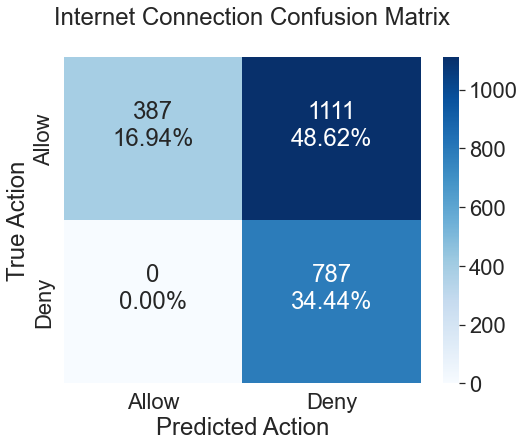

In [77]:
from sklearn.metrics import confusion_matrix

def plot_confusion(cf_matrix):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=2)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
    cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
    cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n' for v1, v2 in
    zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    x_axis_labels = ['Allow','Deny']
    y_axis_labels = ['Allow','Deny']
    ax = plt.axes()
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues',xticklabels=x_axis_labels, yticklabels=y_axis_labels)
    ax.set_title('   Internet Connection Confusion Matrix\n')
    plt.xlabel("Predicted Action")
    plt.ylabel("True Action") 


lr_cm = confusion_matrix(y_test,vw_predictions)
plot_confusion(lr_cm)

In [82]:
from sklearn.metrics import classification_report
print(classification_report(y_test,vw_predictions, 
                            target_names=['allow','deny']))

              precision    recall  f1-score   support

       allow       1.00      0.26      0.41      1498
        deny       0.41      1.00      0.59       787

    accuracy                           0.51      2285
   macro avg       0.71      0.63      0.50      2285
weighted avg       0.80      0.51      0.47      2285

